In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
#Options
params = {'text.usetex' : True,
          'font.size' : 10,
          'font.family' : 'lmodern'
          }
plt.rcParams.update(params) 

n = 10
DNS speedup (GPU - CPU): 64.13
n = 11
DNS speedup (GPU - CPU): 251.98
n = 12
DNS speedup (GPU - CPU): 364.15
n = 13
DNS speedup (GPU - CPU): 393.75
n = 10
QIS speedup (GPU - CPU): 8.43
n = 11
QIS speedup (GPU - CPU): 9.28
n = 12
QIS speedup (GPU - CPU): 10.44
n = 13
QIS speedup (GPU - CPU): 11.89


/var/folders/by/tjkhpdvj401cj92bnwvg228h0000gn/T/ipykernel_83600/4248244138.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


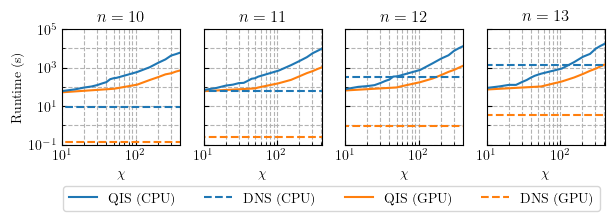

In [2]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

files_cutn = [
    "GPU_runtime_cuTensorNet/runtime_GPU_H100_10.p",
    "GPU_runtime_cuTensorNet/runtime_GPU_H100_11.p",
    "GPU_runtime_cuTensorNet/runtime_GPU_H100_12.p",
    "GPU_runtime_cuTensorNet/runtime_GPU_H100_13.p"
]

files_quimb = [
    "CPU_runtime_quimb/runtime_CPU_H100_10.p",
    "CPU_runtime_quimb/runtime_CPU_H100_11.p",
    "CPU_runtime_quimb/runtime_CPU_H100_12.p",
    "CPU_runtime_quimb/runtime_CPU_H100_13.p"
]

data_cutn = {}
for file in files_cutn:
    with open(file, 'rb') as fp:
        data = pickle.load(fp)
    for key, el in data.items():
        n, chi = key
        if chi in range(6, 50):
            continue
        time = el
        if n in data_cutn.keys():
            data_cutn[n][0].append(chi)
            data_cutn[n][1].append(time)
        else:
            data_cutn[n] = [[chi], [time]]

data_quimb = {}
for file in files_quimb:
    with open(file, 'rb') as fp:
        data = pickle.load(fp)
    for key, el in data.items():
        n, chi = key
        time = el
        if n in data_quimb.keys():
            data_quimb[n][0].append(chi)
            data_quimb[n][1].append(time)
        else:
            data_quimb[n] = [[chi], [time]]

def sort_dict(input_dict):
    output_dict = {}
    for key, el in input_dict.items():
        n = key
        chi_list, time_list = el

        chi_list_new = [chi for chi, _ in sorted(zip(chi_list, time_list))]
        time_list_new = [time for _, time in sorted(zip(chi_list, time_list))]

        output_dict[n] = [chi_list_new, time_list_new]

    return output_dict

data_cutn = sort_dict(data_cutn)
data_quimb = sort_dict(data_quimb)


data_dns_cpu = {
    10: [[0, 700], [8.84]*2],
    11: [[0, 700], [61.56]*2],
    12: [[0, 700], [324.11]*2],
    13: [[0, 700], [1364.02]*2],
}

data_dns_gpu = {
    10: [[0, 700], [0.13784879207611084]*2],
    11: [[0, 700], [0.24430412769317628]*2],
    12: [[0, 700], [0.8900508379936218]*2],
    13: [[0, 700], [3.4641390323638914]*2],
}

speedup_dns = {}
for key in data_dns_cpu.keys():
    time_cpu = data_dns_cpu[key][1][0]
    time_gpu = data_dns_gpu[key][1][0]
    speedup_dns[key] = time_cpu/time_gpu

num_plots = len(data_cutn)

fig, ax = plt.subplots(1, num_plots, figsize=(7, 1.5), sharey=True, gridspec_kw={'wspace': 0.2})
mapping = {}
ax[0].set_ylabel("Runtime (s)")
time_405_GPU = []
time_405_CPU = []
for i, (key, el) in enumerate(data_cutn.items()):
    n = key
    chi_list, time_list = el
    ax[i].plot(chi_list, time_list, label="QIS (GPU)", c=colors[1])
    
    ax[i].plot(data_dns_gpu[n][0], data_dns_gpu[n][1], label="DNS (GPU)", c=colors[1], ls='dashed')
    ax[i].plot(data_dns_cpu[n][0], data_dns_cpu[n][1], label="DNS (CPU)", c=colors[0], ls='dashed')
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_ylim((1e-1, 1e5))
    ax[i].set_yticks([1e0, 1e2, 1e4], minor=True, labels=[""]*3)
    ax[i].set_xlim([10, 405])
    ax[i].set_xlabel(r"$\chi$")
    ax[i].set_title(fr"$n = {n}$")
    ax[i].tick_params(which='both', direction="in")
    # ax[i].xaxis.set_minor_locator(MultipleLocator(100))
    # ax[i].xaxis.grid(True, which='minor')
    ax[i].grid(True, ls="--", c='0.7', which='both')
    mapping[n] = i

    print(f"n = {n}")
    for l, k in enumerate(chi_list):
        if k == 405:
            time_405_GPU.append(time_list[l])
    print(f"DNS speedup (GPU - CPU): {np.round(speedup_dns[n], 2)}")
# ax[0].plot(np.linspace(0, 400, 400), np.linspace(0, 400, 400)**1)
for key, el in data_quimb.items():
    n = key
    i = mapping[n]
    chi_list, time_list = el
    l_405 = 0
    for l, k in enumerate(chi_list):
        if k == 405:
            l_405 = l
            time_405_CPU.append(time_list[l])
    print(f"n = {n}")
    print(f"QIS speedup (GPU - CPU): {np.round(time_list[l_405]/time_405_GPU[i], 2)}")
    ax[i].plot(chi_list, time_list, label="QIS (CPU)", c=colors[0])

handles = [[], []]
handles[0].append(ax[0].get_legend_handles_labels()[0][3])
handles[1].append(ax[0].get_legend_handles_labels()[1][3])
handles[0].append(ax[0].get_legend_handles_labels()[0][2])
handles[1].append(ax[0].get_legend_handles_labels()[1][2])
handles[0].append(ax[0].get_legend_handles_labels()[0][0])
handles[1].append(ax[0].get_legend_handles_labels()[1][0])
handles[0].append(ax[0].get_legend_handles_labels()[0][1])
handles[1].append(ax[0].get_legend_handles_labels()[1][1])

fig.legend(*handles, loc='upper center', bbox_to_anchor=(0.51, -0.12), ncol=6, fancybox=True)
fig.tight_layout()
plt.savefig("runtime_scaling.pdf", bbox_inches="tight")
plt.show()
